In [51]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2 as cv
from dataset import CustomImageDataset
from torch.utils.data import DataLoader
from skimage import exposure
from skimage.exposure import match_histograms
import ImageProcessing as IP
import torchvision.transforms as transforms

Declaring image directories

In [52]:
RGB_dir ='./Sample RGB/'
Depth_dir = './Sample Depth/'
ref_dir = './Manhatta Frames/'

Creating custom dataset

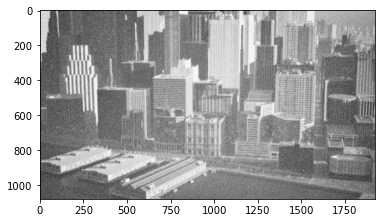

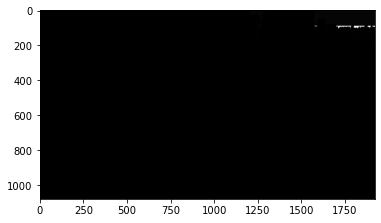

In [53]:
import importlib
importlib.reload(IP)

data = CustomImageDataset(img_dir= RGB_dir, depth_dir= Depth_dir, transform= IP.rgb_transform, histogram_matching= IP.histogram_matching)
data_loader = DataLoader(data, batch_size=2, shuffle=True) #Loads a random RGB, Depth couple from the dataset
rgb_img, depth_img = next(iter(data_loader)) #Unsqueezes and converts to tensor, may need to squeeze(0)
plt.imshow(rgb_img[0][0,:,:].squeeze().numpy(), cmap='gray')
plt.show()
plt.imshow(depth_img[0], cmap='gray')
plt.show()

In [54]:
rgb_img.shape

torch.Size([2, 3, 1080, 1920])

Transforming RGB images

In [55]:
#import importlib
#importlib.reload(IP)
#
#test_img = IP.rgb_transform(rgb_img[0])
#plt.imshow(test_img.transpose(0,2).transpose(0,1), cmap='gray')

Matching histogram

In [56]:
#matched_img = IP.histogram_matching(test_img, ref_dir)
#print(np.array(matched_img.shape[::-1]))
#matched_img.transpose_(0,2).transpose_(0,1)
#plt.imshow(matched_img.numpy(), cmap='gray')

Processing a scene for consistent depth prediction

In [57]:
for i,img in enumerate(rgb_img):
    cv.imwrite('./consistent_depth-main/color_full/' + str(i) + '.jpeg' , rgb_img[i].squeeze().numpy())


### Fine-tuning huggingface model: Intel/dpt-large

In [58]:
from transformers import AutoFeatureExtractor, DPTForDepthEstimation
from PIL import Image

extractor = AutoFeatureExtractor.from_pretrained("Intel/dpt-large")

model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

loading feature extractor configuration file https://huggingface.co/Intel/dpt-large/resolve/main/preprocessor_config.json from cache at C:\Users\ardat/.cache\huggingface\transformers\2d2cf5cf3080b8287091068a5823e7803b663a721baf3b8b4cb9927b1a6719cf.844af03489b54f685bcc44ca6e88f2cecdbe2f6ddecd6ca1642cdc3d7f6b485e
Feature extractor DPTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "ensure_multiple_of": 1,
  "feature_extractor_type": "DPTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "keep_aspect_ratio": false,
  "resample": 2,
  "size": 384
}

loading configuration file https://huggingface.co/Intel/dpt-large/resolve/main/config.json from cache at C:\Users\ardat/.cache\huggingface\transformers\1307b75b3b0803c9dc1b180ce6d25906c79fd68e5aaa92a1c10a7fab0bcbf912.293fcb7e46c726c752f3a6dfe4a0f729a3e7021ab9c9c23d8a25461cce00d3fd
Model config DPTConfig {
  "architectures": [
    "DPTForDepthEstimation"
  ],
  

In [59]:
#from transformers import TrainingArguments, Trainer
#from datasets import load_metric
#
#training_args = TrainingArguments(output_dir="test_trainer")
#metric = load_metric("accuracy")
#
#def compute_metrics(eval_pred):
#    logits, labels = eval_pred
#    predictions = np.argmax(logits, axis=-1)
#    return metric.compute(predictions=predictions, references=labels)
#
#training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")
#
#inputs = np.empty(rgb_img.shape)
#for i in range(0,rgb_img.shape[0]):
#    inputs[i] = extractor(images=IP.transform_to_PIL(rgb_img[0]), return_tensors="pt")
#
#trainer = Trainer(
#    model=model,
#    args=training_args,
#    train_dataset= extractor(images=IP.transform_to_PIL(depth_img[0]), return_tensors="pt"),
#    eval_dataset=depth_img[0],
#    #compute_metrics=compute_metrics,
#)
#

In [60]:
#trainer.train()

In [61]:
#from transformers import TrainingArguments, Trainer
#inputs = extractor(images=rgb_img[0], return_tensors="pt")
#
#with torch.no_grad():
#    outputs = model(**inputs)
#    predicted_depth = outputs.predicted_depth
#print(type(predicted_depth))
#
#prediction = torch.nn.functional.interpolate(
#    predicted_depth.unsqueeze(0),
#    size=rgb_img.size,
#    mode="bicubic",
#    align_corners=False,
#)
#
## visualize the prediction
#output = prediction.squeeze().cpu().numpy()
#formatted = (output * 255 / np.max(output)).astype("uint8")
#depth = Image.fromarray(formatted)
#
#depth.show()

In [62]:
#depth_img.shape

In [63]:
torch.cat((depth_img[0].unsqueeze(0), depth_img[0].unsqueeze(0), depth_img[0].unsqueeze(0))).shape

torch.Size([3, 1080, 1920])

In [64]:
from transformers import DPTFeatureExtractor, DPTForDepthEstimation
from transformers import TrainingArguments, Trainer
from datasets import load_metric
import torch
import numpy as np
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

#print(type(image))
# prepare image for the model


convert = transforms.PILToTensor()
#print(convert(image).shape, rgb_img[0].shape)
inputs = feature_extractor(images=rgb_img[0], return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= extractor(images=rgb_img[0], return_tensors="pt"),
    eval_dataset=torch.cat((depth_img[0].unsqueeze(0), depth_img[0].unsqueeze(0), depth_img[0].unsqueeze(0))).shape,
    compute_metrics=compute_metrics,
)


loading feature extractor configuration file https://huggingface.co/Intel/dpt-large/resolve/main/preprocessor_config.json from cache at C:\Users\ardat/.cache\huggingface\transformers\2d2cf5cf3080b8287091068a5823e7803b663a721baf3b8b4cb9927b1a6719cf.844af03489b54f685bcc44ca6e88f2cecdbe2f6ddecd6ca1642cdc3d7f6b485e
Feature extractor DPTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "ensure_multiple_of": 1,
  "feature_extractor_type": "DPTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "keep_aspect_ratio": false,
  "resample": 2,
  "size": 384
}

loading configuration file https://huggingface.co/Intel/dpt-large/resolve/main/config.json from cache at C:\Users\ardat/.cache\huggingface\transformers\1307b75b3b0803c9dc1b180ce6d25906c79fd68e5aaa92a1c10a7fab0bcbf912.293fcb7e46c726c752f3a6dfe4a0f729a3e7021ab9c9c23d8a25461cce00d3fd
Model config DPTConfig {
  "architectures": [
    "DPTForDepthEstimation"
  ],
  